found here:
https://github.com/parrt/msds621

## Creditcard-Fraud: imbalanced data

In [1]:
from dtreeviz.trees import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, f1_score, accuracy_score,\
                            roc_auc_score, average_precision_score, precision_recall_curve, auc,\
                            roc_curve

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from copy import copy
from numpy import random

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'png'

In [2]:
# https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv("../data/creditcard.csv")
df.shape

(284807, 31)

In [3]:
no_fraud = df.index[df['Class']==0]
fraud = df.index[df['Class']==1].tolist()
sampled = random.choice(no_fraud, size=100000, replace=False).tolist()
df = df.loc[fraud + sampled, ].reset_index()
df.to_csv("../data/creditcard_subsampled.csv", header=True, index=False)

In [4]:
print(f"num anomalies {np.sum(df['Class']==1)}/{len(df)} = {100*np.sum(df['Class']==1)/len(df):.2f}%")

num anomalies 492/100492 = 0.49%


## what will our accuracy be ad hoc?

In [5]:
# from sklearn.metrics.classification import precision_recall_fscore_support
from sklearn.metrics import recall_score, precision_score, f1_score
pd.crosstab(df.Class.astype(str) + "_true", pd.Series(np.zeros_like(df.Class)).astype(str) + "_Actual")

col_0,0_Actual
Class,
0_true,100000
1_true,492


 - $\text{accuracy} = \frac{\text{true positives + true negatives}}{\text{true negatives + false negatives + true positives + false positives}} = \frac{0 + 284315}{492 + 284315} = 0.998$

## get a model

In [6]:
import lightgbm
model = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, 
                                n_estimators=500, subsample_for_bin=20000, objective='binary', 
                                subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                                n_jobs=- 1, silent=True, importance_type='split',
                                is_unbalance = False, scale_pos_weight = 1.0)


## train / test split

In [7]:
X, y = df.drop('Class', axis=1), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
clf = copy(model)
clf.fit(X_train,y_train)



LGBMClassifier(is_unbalance=False, n_estimators=500, objective='binary',
               scale_pos_weight=1.0, subsample_for_bin=20000)

In [8]:
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)
df_conf = pd.DataFrame(confusion, columns=['non-Fraud','Fraud'], index=['non-Fraud','Fraud'])
df_conf

,non-Fraud,Fraud
non-Fraud,20011,1
Fraud,19,68


 - $\text{Precision}=\frac{\text{TP}}{\text{TP + FP}}$
 - $\text{Recall}=\frac{\text{TP}}{\text{TP + FN}}$

In [9]:
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.986, Recall 0.782
F1 0.87, Accuracy 0.9990
ROC 0.97, AUC PR 0.86


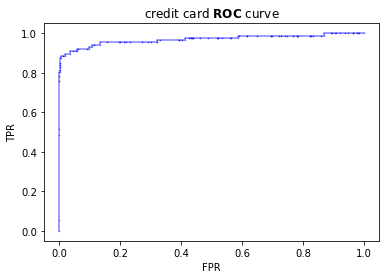

In [10]:
plt.plot(FPR, TPR, 'b.-', markersize=1, alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"credit card $\\bf ROC$ curve")
plt.savefig("/tmp/ROC-curve.png", dpi=200)
plt.show()

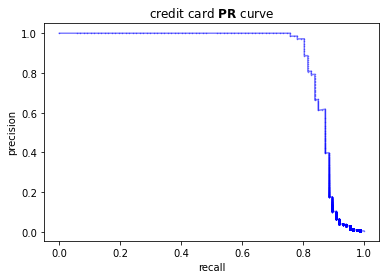

In [11]:
plt.plot(recall, precision, 'b.-', markersize=1, alpha=0.5)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title(f"credit card $\\bf PR$ curve")
plt.savefig("/tmp/PR-curve.png", dpi=200)
plt.show()

In [12]:
# keep the workspace tidy
y_pred, confusion, y_pred_proba, recision, recall = None, None, None, None, None
del y_pred, confusion, y_pred_proba, recision, recall

## proper test set?

In [13]:
# must split out test set first but get 20% from each class at original ratio of fraud/good
df_good = df[df['Class']==0]
df_fraud = df[df['Class']==1]

df_train_good, df_test_good   = train_test_split(df_good, test_size=0.20)
df_train_fraud, df_test_fraud = train_test_split(df_fraud, test_size=0.20)

df_train = pd.concat([df_train_good, df_train_fraud], axis=0)
df_test  = pd.concat([df_test_good, df_test_fraud], axis=0)

print(f"TRAIN num fraud {np.sum(df_train['Class']==1)}/{len(df_train)} = {100*np.sum(df_train['Class']==1)/len(df_train):.2f}%")
print(f"TEST num fraud {np.sum(df_test['Class']==1)}/{len(df_test)} = {100*np.sum(df_test['Class']==1)/len(df_test):.2f}%")

TRAIN num fraud 393/80393 = 0.49%
TEST num fraud 99/20099 = 0.49%


In [14]:
# keep the workspace tidy
df_good, df_fraud, df_train_good, df_test_good, df_train_fraud, df_test_fraud, df_train, df_test =None,None,None,None, None, None, None,None
del df_good, df_fraud, df_train_good, df_test_good, df_train_fraud, df_test_fraud, df_train, df_test

we can also do this with a sklearn data-set splitter:

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.2, train_size=0.8)
idx = next(splitter.split(df, df.Class))
train_idx = idx[0]
test_idx = idx[1]

In [16]:
len(test_idx)

20099

In [17]:
df_train = df.loc[train_idx]
df_test = df.loc[test_idx]
print(f"TRAIN num fraud {np.sum(df_train['Class']==1)}/{len(df_train)} = {100*np.sum(df_train['Class']==1)/len(df_train):.2f}%")
print(f"TEST num fraud {np.sum(df_test['Class']==1)}/{len(df_test)} = {100*np.sum(df_test['Class']==1)/len(df_test):.2f}%")

TRAIN num fraud 394/80393 = 0.49%
TEST num fraud 98/20099 = 0.49%


In [18]:
X_train, y_train = df_train.drop('Class', axis=1), df_train['Class']
X_test, y_test = df_test.drop('Class', axis=1), df_test['Class']
clf = copy(model)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19980,21
T,29,69


In [19]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.767, Recall 0.704
F1 0.73, Accuracy 0.9975
ROC 0.86, AUC PR 0.72


In [20]:
# keep workspace tidy
df, idx, df_train, df_test, clf, precision, recall, y_pred, y_pred_proba = None, None, None, None, None, None, None, None,None
df, idx, df_train, df_test, clf, precision, recall, y_pred, y_pred_proba

(None, None, None, None, None, None, None, None, None)

# Strategies for the imbalanced case:
 - oversample the minority class
 - undersample the majority class
 - do both of the former two suggestions
 - oversample only the cases that get missclassified
 - set `is_unbalance` and/or `scale_pos_weight` parameters in lightgbm

## oversample fraud

In [21]:
import imblearn
from imblearn.over_sampling import SMOTE, ADASYN
X_train_ov, y_train_ov = SMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)

In [22]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19997,4
T,17,81


In [23]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.953, Recall 0.827
F1 0.89, Accuracy 0.9990
ROC 0.98, AUC PR 0.89


In [24]:
# needs too much RAM: X_train_ov, y_train_ov = ADASYN().fit_resample(X_train, y_train)

In [25]:
X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf = None, None, None, None, None, None, None
del X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf

In [26]:
# needs to much RAM for me:
from imblearn.over_sampling import BorderlineSMOTE
X_train_ov, y_train_ov = BorderlineSMOTE(sampling_strategy=0.05).fit_resample(X_train, y_train)

In [27]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19996,5
T,19,79


In [28]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.940, Recall 0.806
F1 0.87, Accuracy 0.9988
ROC 0.98, AUC PR 0.89


In [29]:
X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf = None, None, None, None, None, None, None
del X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf

In [30]:
from imblearn.over_sampling import SVMSMOTE
X_train_ov, y_train_ov = SVMSMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)

In [31]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19995,6
T,19,79


In [32]:
# keep the workspace tidy
X_train_ov, y_train_ovm, y_pred, clf = None, None, None, None
del X_train_ov, y_train_ovm, y_pred, clf

## weigh minority class

In [33]:
clf = copy(model)
clf.set_params(is_unbalance = True)
#, scale_pos_weight

LGBMClassifier(is_unbalance=True, n_estimators=500, objective='binary',
               scale_pos_weight=1.0, subsample_for_bin=20000)

In [34]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19154,847
T,13,85


In [35]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.091, Recall 0.867
F1 0.17, Accuracy 0.9572
ROC 0.91, AUC PR 0.48


In [36]:
clf.set_params(is_unbalance=False, scale_pos_weight=9.0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19732,269
T,98,0


In [37]:
# house-keeping
y_pred_proba, precision, recall, clf, y_pred = None, None, None, None, None
del y_pred_proba, precision, recall, clf, y_pred

## Undersample Fraud

In [38]:
from imblearn.under_sampling import RandomUnderSampler
X_train_u, y_train_u = RandomUnderSampler(sampling_strategy=0.5).fit_resample(X_train, y_train)
print(X_train.shape, X_train_u.shape)

(80393, 31) (1182, 31)


In [39]:
clf = copy(model)
clf.fit(X_train_u,y_train_u)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19672,329
T,8,90


In [40]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.215, Recall 0.918
F1 0.35, Accuracy 0.9832
ROC 0.98, AUC PR 0.85


In [41]:
y_pred_proba, y_pred, precision, recall, clf, X_train_u, y_train_u = None, None, None, None, None, None, None
y_pred_proba, y_pred, precision, recall, clf, X_train_u, y_train_u

(None, None, None, None, None, None, None)

## do both: oversample minority class and undersample majority class

In [42]:
# not enough RAM
# from imblearn.combine import SMOTEENN
# X_train_uo, y_train_uo = SMOTEENN().fit_resample(X_train, y_train)
# X_train_uo, y_train_uo = SMOTETomek(random_state=0).fit_resample(X_train, y_train)
# print(X_train.shape, X_train_uo.shape)

## get best combination

In [43]:
df = pd.read_csv("../data/creditcard_subsampled.csv")
X, y = df.drop('Class', axis=1), df['Class']

In [44]:
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import BorderlineSMOTE
clf = copy(model)
clf.set_params(num_leaves=64)
borderline = BorderlineSMOTE(random_state=88)
grid = {'class__n_estimators': [200, 500],
        'class__neg_bagging_fraction': [0.1, 0.3],
        'class__max_depth' : [4, 6, 8, -1],
        'class__learning_rate' :[0.05, 0.1],
        'sampling__sampling_strategy' :[0.1, 0.3, 0.5]}
pipeline = Pipeline([('sampling', borderline), ('class', clf)])
grid_cv = GridSearchCV(pipeline, grid, scoring = 'f1', cv = 5)
   
grid_cv.fit(X, y)
display(grid_cv.best_score_, grid_cv.best_params_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

0.7663259684096551

In [48]:
grid_cv.best_params_

{'class__learning_rate': 0.1,
 'class__max_depth': 4,
 'class__n_estimators': 500,
 'class__neg_bagging_fraction': 0.1,
 'sampling__sampling_strategy': 0.3}

ValueError: x, y, and format string must not be None

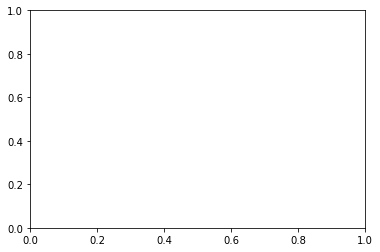

In [45]:
plt.plot(recall, precision, 'b.-', markersize=1, alpha=0.5)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title(f"Upsampled credit card $\\bf PR$ curve")
plt.savefig("/tmp/PR-curve-balanced.png", dpi=200)
plt.show()